In [2]:
#IMPORT LIBRARIES
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from fastai.tabular import add_datepart
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline
import pmdarima as pm


#READ TXT FILES AND CREATE A DATAFRAME FROM THE COLLECTIVE DATA
cpu = []
dates = []
with open("/Users/spyroschouliaras/Desktop/file.txt", "r") as f:
  for line in f:
    cpu.append(float(line.strip()))

with open("/Users/spyroschouliaras/Desktop/file2.txt", "r") as f:
  for line in f:
    dates.append(str(line.strip()))


cpuarray = np.array(cpu)
datesarray = np.array(dates)

df = pd.DataFrame({'Date': dates, 'CPU' :cpu})





/Users/spyroschouliaras/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/spyroschouliaras/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Text(0, 0.5, 'CPU Usage %')

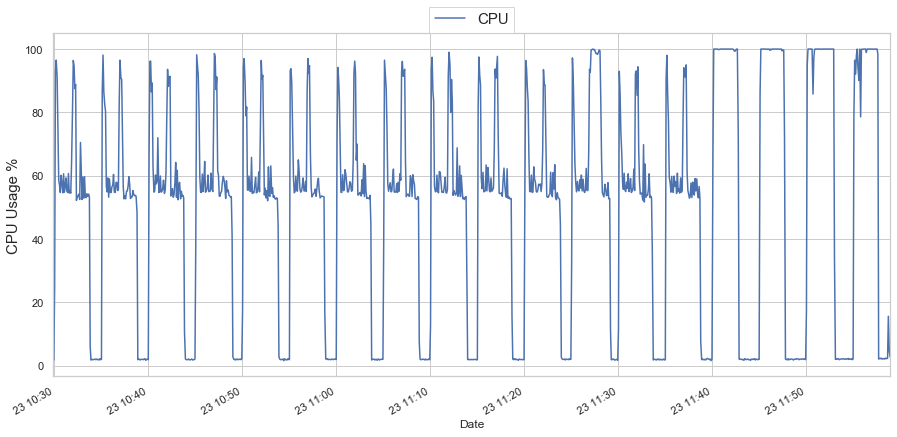

In [3]:
# #Adding the anomalous wavelet to the graph
sns.set(rc={'figure.figsize':(15, 7)},style = 'whitegrid')
nm = df.copy()
# anomalous = df.iloc[-220:-170]
# anomalous2=df.iloc[-280:-230]
anomalous = nm.iloc[-222:-172]
anomalous2= nm.iloc[-280:-230]

anomalous2.CPU[::] = anomalous.CPU[::]
anomalous2['Date'] = pd.to_datetime(anomalous2.Date,format='%Y-%m-%d')
anomalous2.index = anomalous['Date']

anomalous2 = anomalous2.replace(0,1)

anomalous2.CPU[-20:-5]= 97

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

df = df.replace(0,1)
df['CPU'].plot()


fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, fontsize = 15)
plt.ylabel('CPU Usage %',fontsize=15)




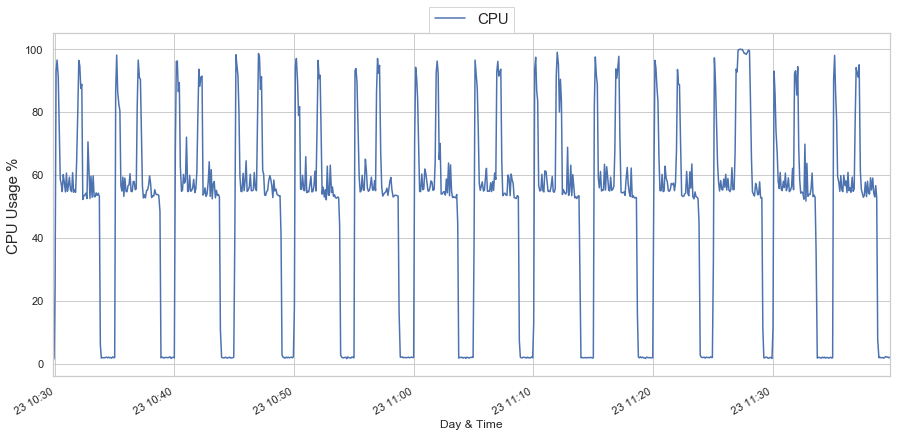

In [4]:
#VISUALISE THE NORMAL RUNS
df = df.iloc[:-220]
df.iloc[0,df.columns.get_loc('CPU')] = 1.0

df['CPU'].plot()
plt.xlabel('Day & Time')
plt.ylabel('CPU Usage %',fontsize=15)

fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3, fontsize = 15)

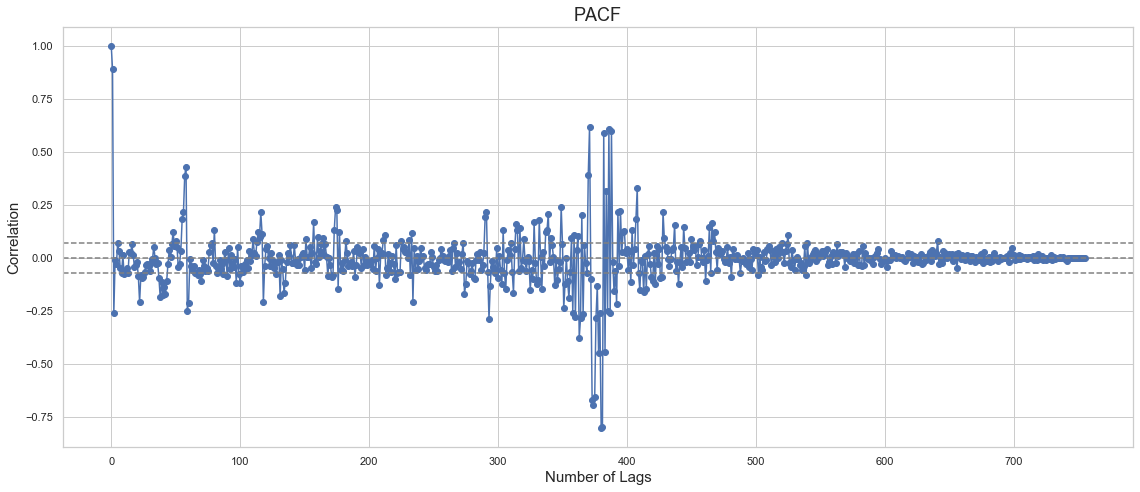

In [5]:
from statsmodels.tsa.stattools import acf, pacf

train = df[:756]
valid = df[756:]

training = train['CPU']
validation = valid['CPU']


lag_pacf = pacf(training, nlags=755, method='ols')

#PLOT PACF
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training)),linestyle='--',color='gray')
plt.title('PACF',fontsize=18)
plt.xlabel('Number of Lags',fontsize=15)
plt.ylabel('Correlation',fontsize=15)
plt.tight_layout()
#AR indicates p = 2 as the first two lags have a good corellation, AR uses a linear combination of the first 2 lag

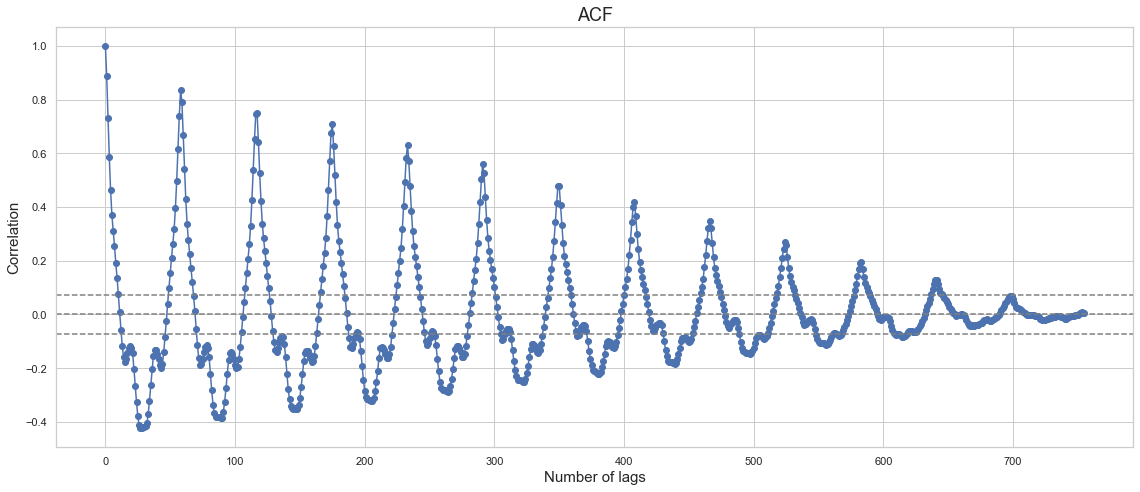

In [6]:
#calling acf function from stattools
lag_acf = acf(training, nlags=755)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training)),linestyle='--',color='gray')
plt.title('ACF',fontsize=18)
plt.xlabel('Number of lags',fontsize = 15)
plt.ylabel('Correlation',fontsize = 15)
plt.tight_layout()



In [7]:
# Augmented Dickey Fuhler test
from pmdarima.arima.stationarity import ADFTest

adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(training)
print(p_val,should_diff)

0.01 False


In [8]:
#ARIMA MODELING
from pmdarima import auto_arima
data = df.sort_index(ascending=True, axis=0)

model = auto_arima(training, start_p=1, start_q=1,max_p=6, max_q=6, m=24,start_P=0, seasonal=False,d=0, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=60)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
print(model.summary())

Fit ARIMA: order=(1, 0, 1); AIC=6017.675, BIC=6036.188, Fit time=0.109 seconds
Fit ARIMA: order=(0, 0, 0); AIC=7247.933, BIC=7257.189, Fit time=0.002 seconds
Fit ARIMA: order=(1, 0, 0); AIC=6064.673, BIC=6078.557, Fit time=0.028 seconds
Fit ARIMA: order=(0, 0, 1); AIC=6571.742, BIC=6585.626, Fit time=0.040 seconds
Fit ARIMA: order=(2, 0, 1); AIC=6015.897, BIC=6039.037, Fit time=0.158 seconds
Fit ARIMA: order=(2, 0, 0); AIC=6013.983, BIC=6032.495, Fit time=0.049 seconds
Fit ARIMA: order=(3, 0, 1); AIC=5992.385, BIC=6020.153, Fit time=0.612 seconds
Fit ARIMA: order=(4, 0, 1); AIC=6018.148, BIC=6050.545, Fit time=0.349 seconds
Fit ARIMA: order=(3, 0, 0); AIC=6015.914, BIC=6039.054, Fit time=0.075 seconds
Fit ARIMA: order=(3, 0, 2); AIC=6019.670, BIC=6052.066, Fit time=0.321 seconds
Fit ARIMA: order=(4, 0, 2); AIC=6002.116, BIC=6039.140, Fit time=1.195 seconds
Total fit time: 2.942 seconds
                              ARMA Model Results                              
Dep. Variable:        

In [9]:
#ARIMA RMSE
rms=np.sqrt(np.mean(np.power((np.array(valid['CPU'])-np.array(forecast['Prediction'])),2)))
rms

28.260729395866733

Text(0, 0.5, 'CPU Usage %')

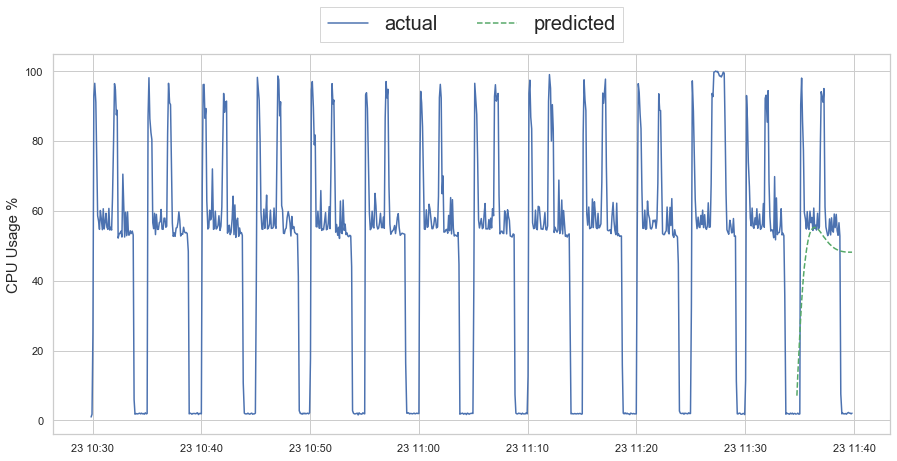

In [10]:
#PLOT ARIMA CPU USAGE PREDICTIONS
sns.set(rc={'figure.figsize':(15, 7)},style = 'whitegrid')
plt.figure(figsize=(15, 7))
line1=plt.plot(train['CPU'],label='actual')
line2=plt.plot(valid['CPU'],'b')
line3=plt.plot(forecast['Prediction'],'g--',label = 'predicted')

from collections import OrderedDict
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=3,fontsize=20)
plt.ylabel('CPU Usage %',fontsize=15)

In [11]:
#DATA PREPERATION
cpuarray = np.array(cpu)
datesarray = np.array(dates)

df = pd.DataFrame({'Date': dates, 'CPU' :cpu})

df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')

df = df.iloc[:-220]

data = df.sort_index(ascending=True, axis=0)

train = data[:756]
valid = data[756:]

training = train['CPU']
validation = valid['CPU']



In [12]:
# define model configuration
# define SARIMA model

sarima = sm.tsa.statespace.SARIMAX(training,order=(1,0,3),seasonal_order=(1,1,1,58)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                CPU   No. Observations:                  756
Model:             SARIMAX(1, 0, 3)x(1, 1, 1, 58)   Log Likelihood               -2559.058
Date:                            Thu, 12 Sep 2019   AIC                           5132.116
Time:                                    20:49:40   BIC                           5163.953
Sample:                                         0   HQIC                          5144.424
                                            - 756                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8269      0.074     11.120      0.000       0.681       0.973
ma.L1         -0.2739      0.078     -3.499      0.000      -0.427      -0.120
ma.L2         -0.1323      0.063     -2.095      0.036      -0.256      -0.009
ma.L3         -0.0498      0.064     -0.775      0.438      -0.176       0.076
ar.S.L58       0.2094      0.073      2.864      0.004       0.066       0.353
ma.S.L58      -0.5432      0.067     -8.077      0.000      -0.675      -0.411
sigma2        88.3456      2.747     32.160      0.000      82.961      93.730
===================================================================================
Ljung-Box (Q):                       54.37   Jarque-Bera (JB):               598.44
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#SARIMA RMSE 
from sklearn.metrics import mean_squared_error

forecast = sarima.predict(756, end=816)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

rms=np.sqrt(np.mean(np.power((np.array(valid['CPU'])-np.array(forecast['Prediction'])),2)))
rms



9.946712450118083

Text(0, 0.5, 'CPU Usage %')

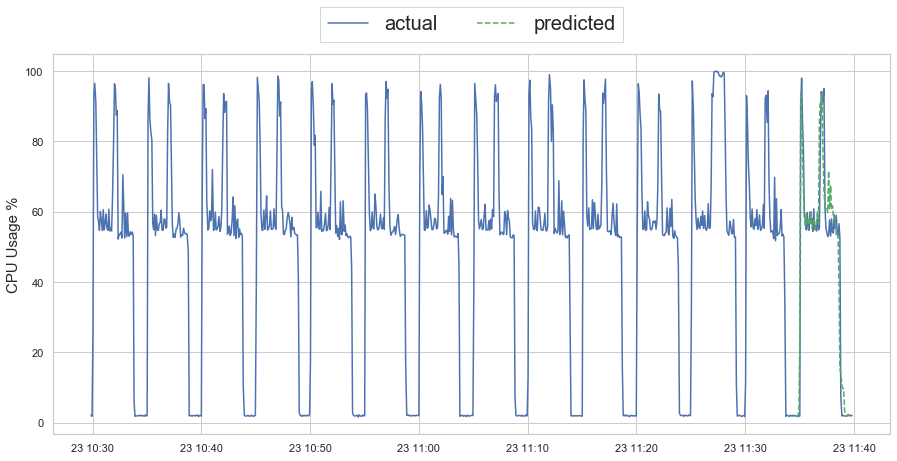

In [14]:
#plot SARIMA CPU PREDICTIONS
sns.set(rc={'figure.figsize':(15, 7)},style = 'whitegrid')

fig,ax = plt.subplots()
import matplotlib.dates as mdates
minute = mdates.MinuteLocator(interval = 10)
h_fmt = mdates.DateFormatter('%H:%M')


ax.xaxis.set_minor_locator(minute)
# plt.figure(figsize=(15, 7))
line1=plt.plot(df.Date[:-60],train['CPU'],label='actual')
line2=plt.plot(df.Date[-60:],valid['CPU'],'b')
line3=plt.plot(df.Date[-60:],forecast['Prediction'],'g--',label = 'predicted')


from collections import OrderedDict
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=3,fontsize=20)
plt.ylabel('CPU Usage %',fontsize=15)

In [15]:
df.shape,train.shape,valid.shape

((816, 2), (756, 2), (60, 2))

In [16]:
anomalous2['Date'] = pd.to_datetime(anomalous2.Date,format='%Y-%m-%d')
anomalous2.index = anomalous2['Date']
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()



(Timestamp('2019-08-23 10:29:52+0000', tz='UTC'),
 Timestamp('2019-08-23 11:34:40+0000', tz='UTC'),
 Timestamp('2019-08-23 11:34:45+0000', tz='UTC'),
 Timestamp('2019-08-23 11:39:49+0000', tz='UTC'))

In [17]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'CPU'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['CPU'][i] = data['CPU'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:756,:]
valid = dataset[756:,:]

# converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))




Using TensorFlow backend.


In [18]:
#LSTM-RNN MODELING
model = Sequential()
model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(x_train, y_train, epochs=10, batch_size=50, verbose=2)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 2s - loss: 0.1152
Epoch 2/10
 - 1s - loss: 0.0755
Epoch 3/10
 - 1s - loss: 0.0658
Epoch 4/10
 - 1s - loss: 0.0601
Epoch 5/10
 - 1s - loss: 0.0552
Epoch 6/10
 - 1s - loss: 0.0509
Epoch 7/10
 - 1s - loss: 0.0473
Epoch 8/10
 - 1s - loss: 0.0444
Epoch 9/10
 - 1s - loss: 0.0420
Epoch 10/10
 - 1s - loss: 0.0397
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
___________________________

In [19]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)



In [20]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [21]:
#CALCULATE RMSE OF LSTM-RNN MODEL
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

19.69681461201753

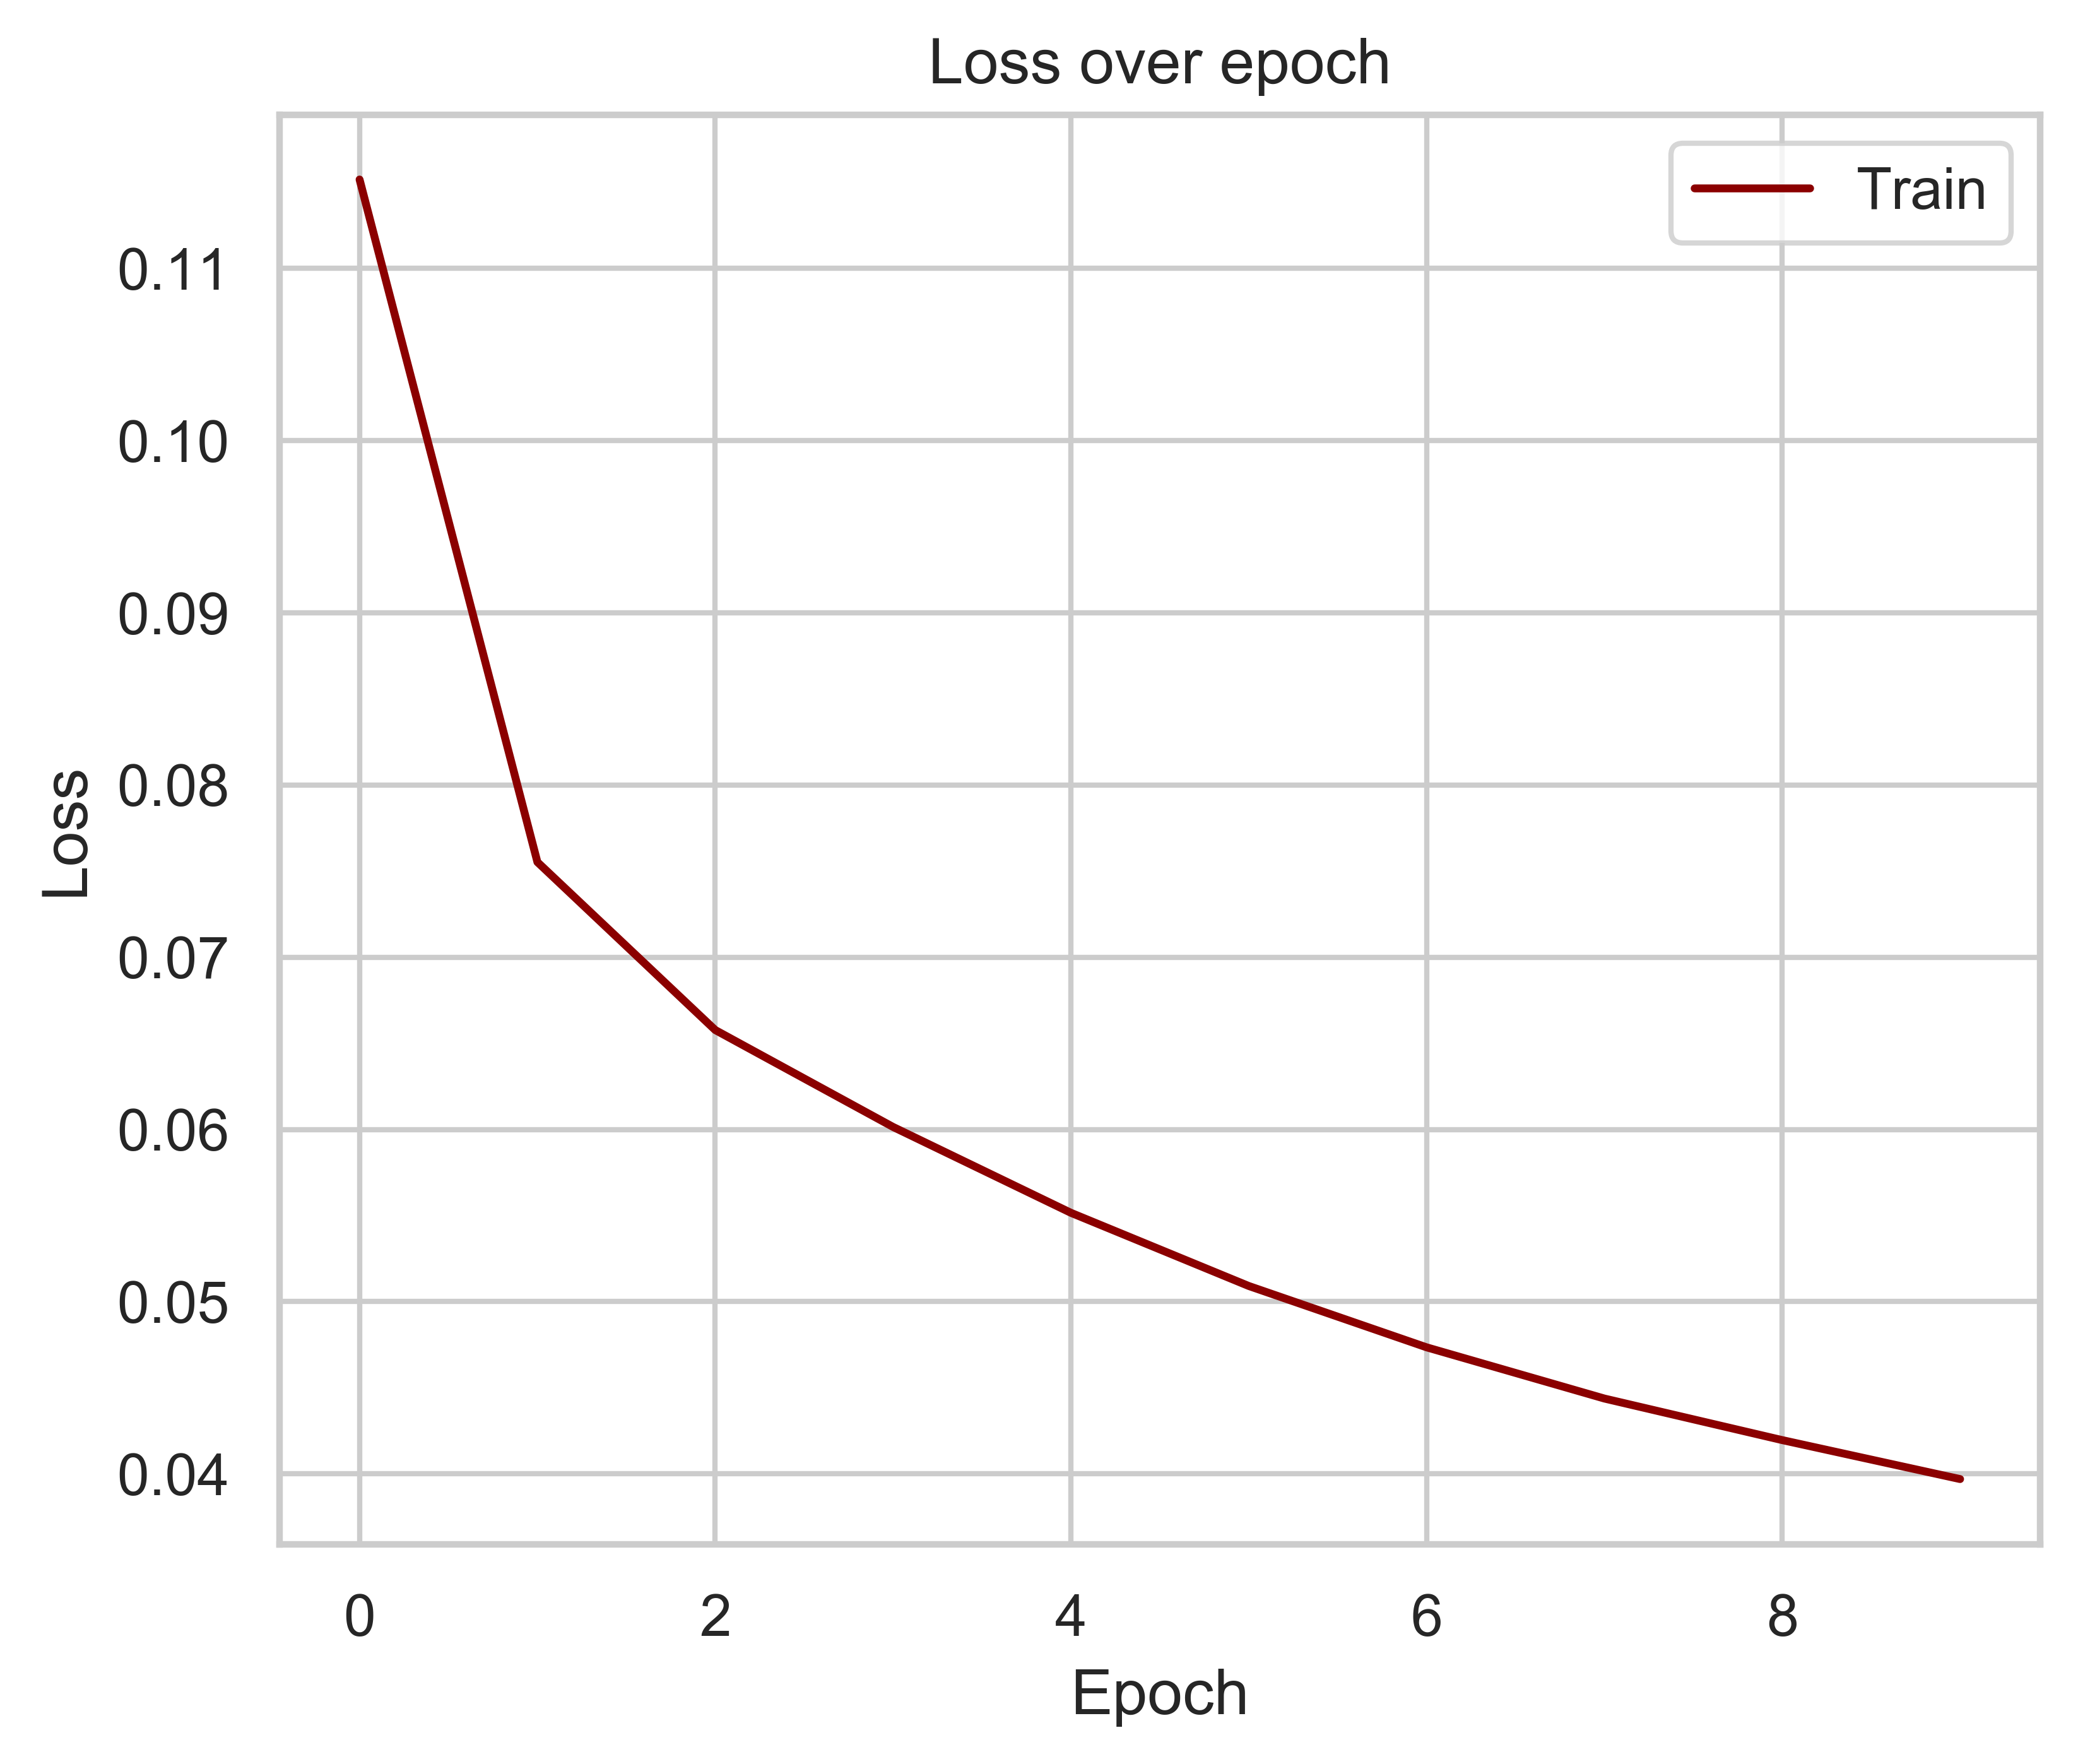

In [22]:
#Loss Over Epoch plot using MSE LOSS FUNCTION
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(6, 5), dpi=600)
plt.plot(history.history["loss"], 'darkred', label="Train")
plt.title("Loss over epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




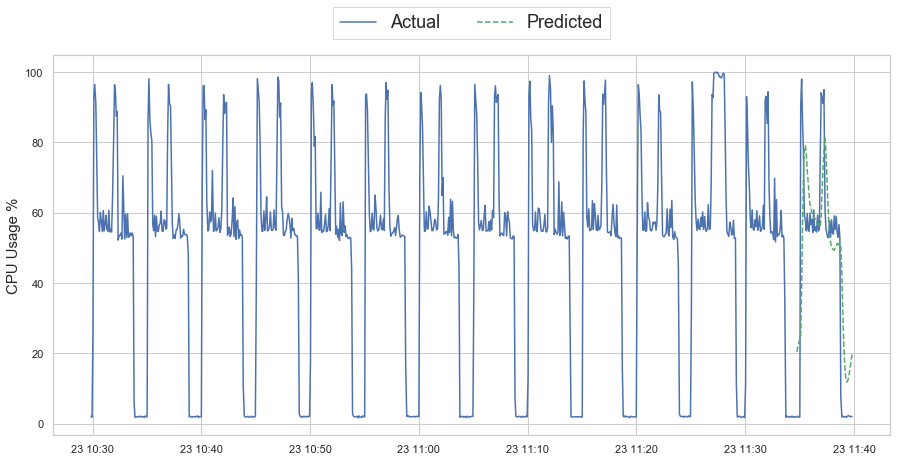

In [23]:
#PLOT LSTM-RNN CPU USAGE PREDICTION
train = new_data[:756]
valid = new_data[756:]
valid['Predictions'] = closing_price  
plt.figure(figsize=(15, 7))
line1=plt.plot(train['CPU'],label='Actual')
line2=plt.plot(valid['CPU'],'b')
line3=plt.plot(valid['Predictions'],'g--',label = 'Predicted')

from collections import OrderedDict
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=3, fontsize = 18)
plt.ylabel('CPU Usage %',fontsize=15)

plt.grid(True)



50 50


1554.1000000000004

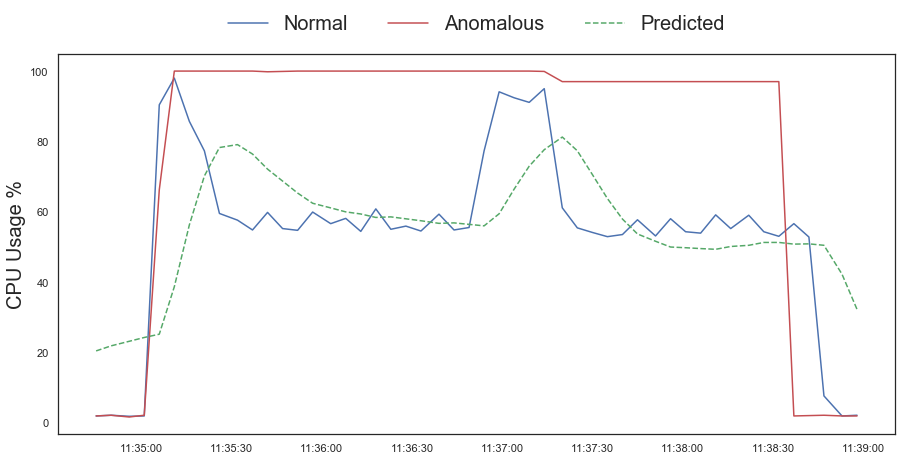

In [24]:
#DTW BETWEEN NORMAL AND ANOMALOUS IS 1554
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

sns.set(rc={'figure.figsize':(15, 7)},style = 'white')
distance, path = fastdtw(valid.CPU[:-10], anomalous2.CPU, dist=euclidean)
DTWAbnormal = distance


plt.plot(valid.CPU[:-10],'b',label='Normal')
plt.plot(anomalous2.CPU,'r',label='Anomalous')
plt.plot(valid.Predictions[:-10],'g--',label = 'Predicted')
print(len(train.CPU[-60:-10]),len(anomalous2.CPU))

fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=3,frameon=False,fontsize=20)

plt.ylabel('CPU Usage %',fontsize=20)
DTWAbnormal

997.1877134323119

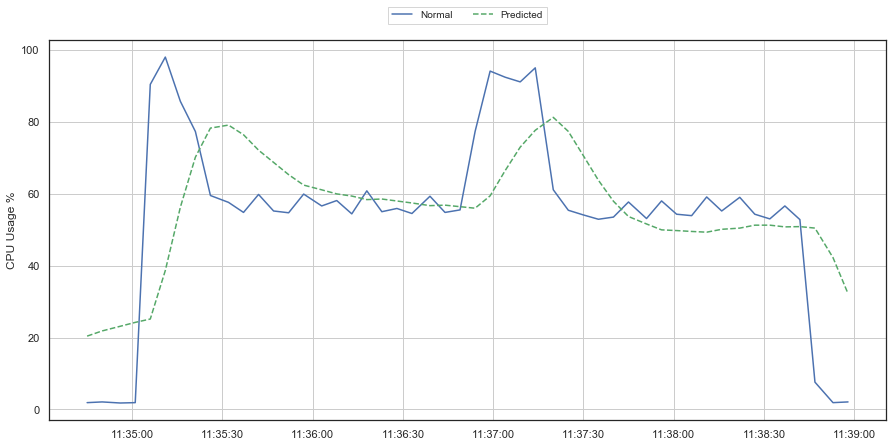

In [25]:
#DTW BETWEEN NORMAL AND PREDICTED IS 170
distance, path = fastdtw(valid.CPU[:-10], valid.Predictions, dist=euclidean)
DTWNormal = distance

plt.plot(valid.CPU[:-10],'b',label='Normal')
plt.plot(valid.Predictions[:-10],'g--',label = 'Predicted')

fontP = FontProperties()
fontP.set_size('small')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=False, shadow=False, ncol=3,fontsize = 10)

plt.grid(True)

plt.ylabel('CPU Usage %')
DTWNormal

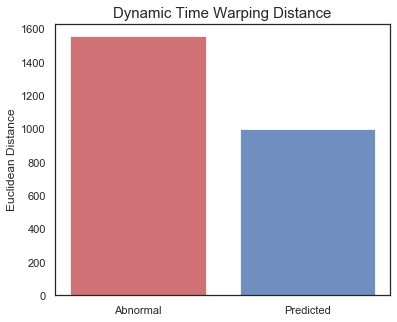

In [26]:
plt.figure(figsize=(6, 5))
objects = ('Abnormal', 'Predicted')
y_pos = np.arange(len(objects))
performance = [DTWAbnormal,DTWNormal]


plt.bar(y_pos, performance, align='center', alpha=0.8,color = ['r','b'])
plt.xticks(y_pos, objects)
plt.ylabel('Euclidean Distance')
plt.title('Dynamic Time Warping Distance',fontsize=15)


plt.show()